# Imports

In [1]:
import os

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# Data

In [2]:
%%capture

from djimaging.user.alpha.utils import database
from djimaging.user.alpha.schemas.alpha_schema import *

# Choose indicator by uncommenting one of the following lines
# indicator = 'calcium'
indicator = 'glutamate'

database.connect_dj(indicator=indicator)

In [3]:
rf_kind, rf_fit_kind = database.get_default_rf_and_rf_fit_kind()

rf_tab = database.get_rf_tab(inc_nl=False)
morph_tab = database.get_morph_tab()

In [4]:
df_field_rfs, field_avg_dx, field_avg_dy = database.get_field_avg_offset()
df_field_rfs.head(3)

experimenter   stim_name  raw_id    cond1  \
date       exp_num field                                             
2020-11-03 1       d1             Ran  noise_1500       1  control   
                   d2             Ran  noise_1500       1  control   
                   d3             Ran  noise_1500       1  control   

                          preprocess_id  dnoise_params_id  rf_glm_params_id  \
date       exp_num field                                                      
2020-11-03 1       d1                 1                 1                10   
                   d2                 1                 1                10   
                   d3                 1                 1                10   

                          split_rf_params_id  rf_contours_params_id  \
date       exp_num field                                              
2020-11-03 1       d1                      1                      1   
                   d2                      1                      1   
                   d3                      1                      1   

                          field_rf_dx_um  field_rf_dy_um  field_rf_d_um  
date       exp_num field                                                 
2020-11-03 1       d1            6.71466        -24.2030        25.1171  
                   d2            1.03766        -25.8439        25.8648  
                   d3            2.81876        -46.3338        46.4194

## Cell and ROI selection

In [5]:
from djimaging.user.alpha.utils.populate_alpha import PROJECT_ROOT
import pickle


with open(f"cell_and_rois_{indicator}.json", "rb") as file:
    cell_and_rois = pickle.load(file)

cell_and_rois

{('20201110', 2): [(4, 5), (3, 2), (1, 4)],
 ('20201103', 1): [(4, 1), (2, 1), (3, 1)]}

In [6]:
palettes = {}

for (cell, rois), colormap in zip(
        cell_and_rois.items(),
        ['Oranges_r', 'Blues_r', 'Greens_r'] if indicator == 'calcium' else ['Oranges_r', 'Greens_r']
):
    palettes[cell] = sns.color_palette(colormap, n_colors=1 + len(rois))

In [7]:
exp_keys = [dict(date=date, exp_num=exp_num) for date, exp_num in cell_and_rois.keys()]

In [8]:
exp_tab = Experiment & exp_keys
field_tab = Field & exp_keys
field_stack_pos_tab = FieldStackPos & exp_keys
linestack_tab = LineStack & exp_keys
roi_pos_metrics_tab = FieldPosMetrics.RoiPosMetrics & exp_keys
roi_cal_stack_pos_tab = FieldCalibratedStackPos.RoiCalibratedStackPos & exp_keys

# Plot

In [9]:
from alphaanalysis import plot as plota

plota.set_default_params(kind='paper')

In [10]:
FIGURE_FOLDER = 'figures'

## Plot mean distances

In [11]:
df_rf = rf_tab.proj('rf_dx_um', 'rf_dy_um', 'rf_d_um').fetch(format='frame')
df_rf.head()

rf_dx_um  \
experimenter date       exp_num field stim_name  raw_id cond1   roi_id preprocess_id dnoise_params_id rf_glm_params_id split_rf_params_id rf_contours_params_id             
Ran          2020-11-03 1       d1    noise_1500 1      control 1      1             1                10               1                  1                      11.14200   
                                                                2      1             1                10               1                  1                      10.74250   
                                                                3      1             1                10               1                  1                       9.39945   
                                                                4      1             1                10               1                  1                       7.44560   
                                                                5      1             1                10               1                  1                       5.00928   

                                                                                                                                                                 rf_dy_um  \
experimenter date       exp_num field stim_name  raw_id cond1   roi_id preprocess_id dnoise_params_id rf_glm_params_id split_rf_params_id rf_contours_params_id             
Ran          2020-11-03 1       d1    noise_1500 1      control 1      1             1                10               1                  1                      -46.6808   
                                                                2      1             1                10               1                  1                      -44.7335   
                                                                3      1             1                10               1                  1                      -36.2182   
                                                                4      1             1                10               1                  1                      -42.8997   
                                                                5      1             1                10               1                  1                      -21.4554   

                                                                                                                                                                 rf_d_um  
experimenter date       exp_num field stim_name  raw_id cond1   roi_id preprocess_id dnoise_params_id rf_glm_params_id split_rf_params_id rf_contours_params_id           
Ran          2020-11-03 1       d1    noise_1500 1      control 1      1             1                10               1                  1                      47.9921  
                                                                2      1             1                10               1                  1                      46.0053  
                                                                3      1             1                10               1                  1                      37.4180  
                                                                4      1             1                10               1                  1                      43.5410  
                                                                5      1             1                10               1                  1                      22.0324

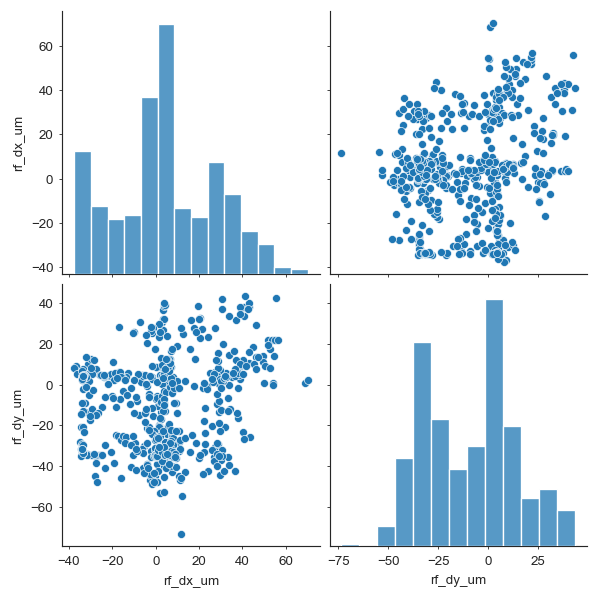

In [12]:
sns.pairplot(data=df_rf, vars=['rf_dx_um', 'rf_dy_um']);

In [13]:
df_rf.rf_dx_um.mean()

4.695911523742454

In [14]:
df_rf.rf_dy_um.mean()

-8.944444724949697

In [15]:
f"{df_rf.rf_d_um.mean():.0f}"

'31'

In [16]:
f"{df_rf.rf_d_um.std():.0f}"

'14'

## Plot sRF outlines on morph

In [17]:
def get_add_offset(cell):
    """Correct with field avg offset"""
    # if indicator == 'glutamate':
    #     return (0, 0)

    date, exp_num = cell
    date = f"{date[:4]}-{date[4:6]}-{date[6:8]}"
    return (-field_avg_dx.loc[date, exp_num], - field_avg_dy.loc[date, exp_num])

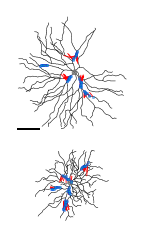

In [18]:
fig, axs = plt.subplots(len(cell_and_rois), 1, figsize=(1.3, 2.6), sharey='all')

for i, (cell, highlight_list) in enumerate(cell_and_rois.items()):
    sm = plota.plot_rois_on_morph(
        axs[i], cell, [], rf_fit_kind,
        morph_tab, rf_tab, roi_pos_metrics_tab, roi_cal_stack_pos_tab, linestack_tab, field_stack_pos_tab, field_tab,
        exp_tab,
        annotate=True, plot_srf_contours=False, plot_srf_offset=True, plot_rf_rois_only=True,
        roi_kws=dict(ms=3, alpha=0.5, mew=0.25, mec='b'),
        rf_contour_kws=dict(lw=0.8, zorder=1000), palettes=palettes,
        add_offset_rf_xy_um=get_add_offset(cell),
        offset_kws=dict(c='red', lw=0.5),
        cmap='plasma',
    )

plota.plot_scale_bar(axs[0], x0=50, y0=0, size=100, pad=-10, text='', orientation='h')

plt.tight_layout(w_pad=0, h_pad=-2, rect=(0, 0.2, 1, 1))

fig.savefig(os.path.join(FIGURE_FOLDER, f'example_cells_with_rf_offsets_{indicator}.pdf'))

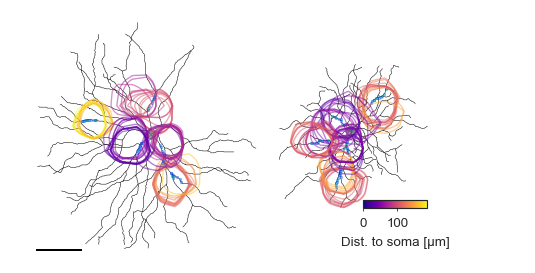

In [19]:
fig, axs = plt.subplots(1, len(cell_and_rois), figsize=(4.5, 2.5), sharex='all')

for i, (cell, highlight_list) in enumerate(cell_and_rois.items()):
    plota.plot_rois_on_morph(
        axs[i], cell, [], rf_fit_kind,
        morph_tab, rf_tab, roi_pos_metrics_tab, roi_cal_stack_pos_tab, linestack_tab, field_stack_pos_tab, field_tab,
        exp_tab,
        annotate=True, plot_srf_contours=True, plot_srf_offset=False, plot_rf_rois_only=True,
        roi_kws=dict(ms=3, alpha=0.5, mew=0.25, mec='b'),
        rf_contour_kws=dict(lw=0.8, zorder=1000), palettes=palettes,
        add_offset_rf_xy_um=get_add_offset(cell),
        offset_kws=dict(c='gray', lw=1),
        cmap='plasma',
    )

plota.plot_scale_bar(axs[0], x0=50, y0=0, size=100, pad=-10, text='', orientation='h')
plt.tight_layout(w_pad=0)

if indicator == 'calcium':
    plota.move_box(axs[-1], dx=-0.05)

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

cax = inset_axes(axs[1], width="25%", height="5%", loc='lower center')
cbar = plt.colorbar(sm, cax=cax, orientation='horizontal', label='Dist. to soma [µm]')

fig.savefig(os.path.join(FIGURE_FOLDER, f'example_cells_with_rfs_{indicator}_horizontal.pdf'))

## All morphs and ROIs

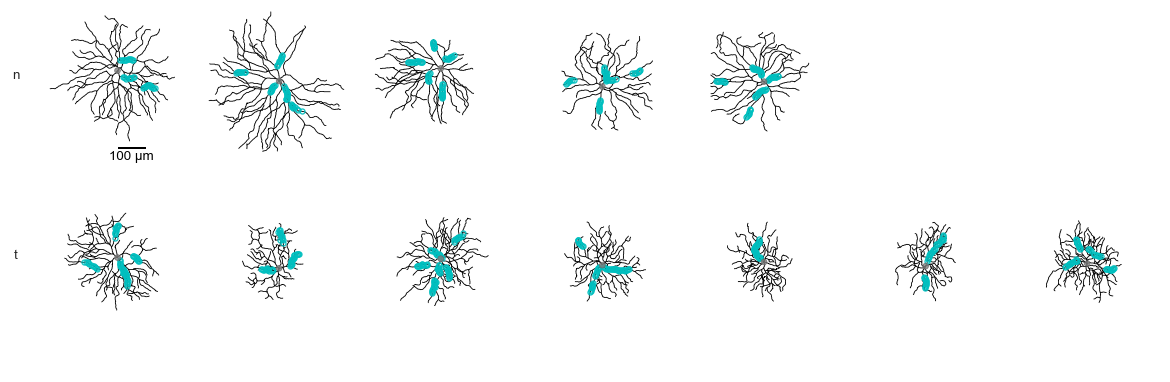

In [20]:
df_morph = database.get_morph_df()
groups = df_morph.groupby('group')
n_cols = np.max(groups['group'].count())
n_rows = 2 * len(groups)

DEBUG = False
order_groups_by = 'temporal_nasal_pos'
plot_side_views = False

fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 5 * len(groups) / 3.), sharex='all',
                        gridspec_kw=dict(height_ratios=(3, 1) * len(groups)), squeeze=False)
sns.despine(left=True, right=True, bottom=True, top=True)

for ax in axs.flat:
    ax.set_aspect('equal', 'datalim')
    ax.set(xticks=[], yticks=[])

# Plot test boxes
for ax in axs.flat:
    ax.vlines([-100, 100], -10, 10, color='r', alpha=float(DEBUG))
    ax.plot([-15, 15, 15, -15, -15], [-15, -15, 15, 15, -15], c='r', alpha=float(DEBUG))

for i, (group_name, group) in enumerate(groups):
    axs[2 * i, 0].set_ylabel(group_name, rotation=0, labelpad=15)

    for j, ((date, exp_num), row) in enumerate(group.sort_values(order_groups_by, ascending=False).iterrows()):
        plota.plot_paths(
            ax=axs[2 * i, j], paths=pd.DataFrame(row.df_paths).path, soma_xyz=row.soma_xyz,
            soma_radius=10, i1=0, i2=1, offset=-row.soma_xyz, lw=0.5, clip_on=False)

        field_ids, roi_ids, rois_pos_xyz = (
                    FieldPosMetrics.RoiPosMetrics() & dict(date=date, exp_num=exp_num) & "field!='SomaROI'").fetch(
            'field', 'roi_id', 'roi_pos_xyz')

        for field_id, roi_id, (x, y, z) in zip(field_ids, roi_ids, rois_pos_xyz):
            axs[2 * i, j].plot(x - row.soma_xyz[0], y - row.soma_xyz[1], marker='o', color='c', ms=3, mfc='none',
                               mew=0.8, alpha=0.9, clip_on=False)

        if plot_side_views:
            plota.plot_paths(
                ax=axs[2 * i + 1, j], paths=pd.DataFrame(row.df_paths).path, soma_xyz=row.soma_xyz,
                soma_radius=10, i1=0, i2=2, offset=-row.soma_xyz, lw=0.5, clip_on=False)
        else:
            axs[2 * i + 1, j].axis('off')

plt.tight_layout(pad=2, h_pad=1, w_pad=1)
fig.align_ylabels()
plota.plot_scale_bar(ax=axs[0, 0], x0=0, y0=-270, size=100, pad=-10, text='100 µm')

fig.savefig(os.path.join(FIGURE_FOLDER, f'all_morphs_and_rois_{indicator}.pdf'), dpi=300, bbox_inches='tight')